<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 6.01 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 09:24:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 14.5 MB/s 
     |████████████████████████████████| 97 kB 9.4 MB/s 
     |████████████████████████████████| 133 kB 65.4 MB/s 
     |████████████████████████████████| 170 kB 69.1 MB/s 
     |████████████████████████████████| 138 kB 64.0 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: wyjhd1ll
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/wyjhd1ll


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: gj04ku2u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 24s 125ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - mean_absolute_error: 0.2189 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0596
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0823 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0846
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0800 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0704
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0905 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1234
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0142 - mean_squared_err

epoch,30
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.04089
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.04848
_runtime,38
_timestamp,1626773162
_step,30
best_val_loss,0.00271


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁
val_loss,▃▆▄█▃▂▆▃▂▃▃▁▁▃▂▂▁▃▁▂▁▁▂▂▃▃▂▂▁▃▁
val_mean_squared_error,▃▆▄█▃▂▆▃▂▃▃▁▁▃▂▂▁▃▁▂▁▁▂▂▃▃▂▂▁▃▁
val_mean_absolute_error,▃▅▄█▄▃▆▄▃▄▃▁▁▃▂▂▁▃▁▃▁▁▃▂▃▄▂▂▂▃▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 1ck8t38b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 18s 355ms/step - loss: 0.1844 - mean_squared_error: 0.1844 - mean_absolute_error: 0.3667 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1091
Epoch 2/100
16/16 [==============================] - 4s 233ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0950 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0664
Epoch 3/100
16/16 [==============================] - 4s 221ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0505 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0491
Epoch 4/100
16/16 [==============================] - 4s 236ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0437 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0491
Epoch 5/100
16/16 [==============================] - 4s 222ms/step - loss: 0.0029 - mean_sq

epoch,99
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02604
val_loss,0.00529
val_mean_squared_error,0.00529
val_mean_absolute_error,0.0614
_runtime,400
_timestamp,1626773581
_step,99
best_val_loss,0.00235


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▂▃▂▃▃▂▂▂▂▃▂▂▂▂▃▁▃▁▂▁▁▁▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o314hs1x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 223ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - mean_absolute_error: 0.2415 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0724
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0769 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0572
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0718 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0538
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0690 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0543
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0073 - mean_squared_error: 0.

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,57
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03616
val_loss,0.00315
val_mean_squared_error,0.00315
val_mean_absolute_error,0.04124
_runtime,21
_timestamp,1626773671
_step,57
best_val_loss,0.00287


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▂▁▂▁▂▁▂▂▁▁▂▁▁▁
val_loss,▆▄▄▄▄▃▃▃▅█▃▅▂▆▂▂▂▄▂▂▃▂▂▄▂▂▁▃▁▁▁▁▁▁▂▂▁▂▁▁
val_mean_squared_error,▆▄▄▄▄▃▃▃▅█▃▅▂▆▂▂▂▄▂▂▃▂▂▄▂▂▁▃▁▁▁▁▁▁▂▂▁▂▁▁
val_mean_absolute_error,▆▄▃▄▄▃▂▅▇█▃▅▂▆▂▂▂▄▂▂▅▄▂▄▂▂▁▃▁▁▁▁▁▂▃▂▁▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oyx7m0jx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 12s 337ms/step - loss: 0.0926 - mean_squared_error: 0.0926 - mean_absolute_error: 0.2392 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0680
Epoch 2/100
16/16 [==============================] - 4s 239ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0693 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0461
Epoch 3/100
16/16 [==============================] - 4s 250ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0492 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0529
Epoch 4/100
16/16 [==============================] - 4s 255ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0421 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0447
Epoch 5/100
16/16 [==============================] - 4s 239ms/step - loss: 0.0026 - mean_sq

epoch,36
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02746
val_loss,0.00226
val_mean_squared_error,0.00226
val_mean_absolute_error,0.03375
_runtime,153
_timestamp,1626773841
_step,36
best_val_loss,0.00223


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▂▂▂▁▂▂▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▂▂▂▁▂▂▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▄▅▃▃▃▃▂▂▂▂▂▁▂▂▂▃▁▁▁▁▁▁▁▃▁▁▁▂▂▁▁▂▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qd57l9uz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 11s 501ms/step - loss: 0.2130 - mean_squared_error: 0.2130 - mean_absolute_error: 0.4035 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - val_mean_absolute_error: 0.2505
Epoch 2/50
8/8 [==============================] - 2s 259ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - mean_absolute_error: 0.2373 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1241
Epoch 3/50
8/8 [==============================] - 2s 261ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1193 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0928
Epoch 4/50
8/8 [==============================] - 2s 254ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0920 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0628
Epoch 5/50
8/8 [==============================] - 2s 231ms/step - loss: 0.0067 - mean_squared_error: 0.

epoch,44
loss,0.00245
mean_squared_error,0.00245
mean_absolute_error,0.03752
val_loss,0.00604
val_mean_squared_error,0.00604
val_mean_absolute_error,0.05239
_runtime,102
_timestamp,1626774010
_step,44
best_val_loss,0.00468


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ef405e56 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 8s 211ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.2917 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0881
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0884 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0797
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0784 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0564
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0693 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0799
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0091 - mean_squared_error: 0.

epoch,27
loss,0.00352
mean_squared_error,0.00352
mean_absolute_error,0.04423
val_loss,0.01469
val_mean_squared_error,0.01469
val_mean_absolute_error,0.1062
_runtime,16
_timestamp,1626774038
_step,27
best_val_loss,0.00387


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▃▂▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁
val_loss,▆▄▂▄▃▃▇▆▆▃▂▂▅▂▁▁▅▁▂▄▂▇▄▂▂▂▄█
val_mean_squared_error,▆▄▂▄▃▃▇▆▆▃▂▂▅▂▁▁▅▁▂▄▂▇▄▂▂▂▄█
val_mean_absolute_error,▆▅▃▅▄▄▇▇▇▄▂▂▄▂▁▁▅▁▂▄▂▆▄▂▂▂▄█
_runtime,▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: clthygba with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 16s 286ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - mean_absolute_error: 0.3085 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0987
Epoch 2/200
31/31 [==============================] - 8s 247ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0985 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0535
Epoch 3/200
31/31 [==============================] - 8s 249ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0472
Epoch 4/200
31/31 [==============================] - 8s 245ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0406 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0476
Epoch 5/200
31/31 [==============================] - 8s 243ms/step - loss: 0.0031 - mean_sq

epoch,44
loss,0.00135
mean_squared_error,0.00135
mean_absolute_error,0.02884
val_loss,0.00256
val_mean_squared_error,0.00256
val_mean_absolute_error,0.03627
_runtime,345
_timestamp,1626774394
_step,44
best_val_loss,0.0025


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6laa20ru with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 57ms/step - loss: 0.6978 - mean_squared_error: 0.6978 - mean_absolute_error: 0.5428 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1412
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1405 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0779
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1151 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.1031
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1324 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1767
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0238 - mean_squared_

epoch,28
loss,0.00411
mean_squared_error,0.00411
mean_absolute_error,0.05047
val_loss,0.00241
val_mean_squared_error,0.00241
val_mean_absolute_error,0.03596
_runtime,23
_timestamp,1626774496
_step,28
best_val_loss,0.00217


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▃█▃▄▃▃▃▁▁▁▂▁▁▃▁▂▁▁▁▁▁▂▁▁▂▂▁
val_mean_squared_error,▆▃▃█▃▄▃▃▃▁▁▁▂▁▁▃▁▂▁▁▁▁▁▂▁▁▂▂▁
val_mean_absolute_error,▆▃▄█▅▅▅▄▄▂▂▂▃▁▂▃▁▄▁▁▁▁▂▂▁▁▂▃▁
_runtime,▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 37jjsu5s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 16s 289ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - mean_absolute_error: 0.2211 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0494
Epoch 2/200
31/31 [==============================] - 7s 237ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0494 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0486
Epoch 3/200
31/31 [==============================] - 8s 250ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0552 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0507
Epoch 4/200
31/31 [==============================] - 8s 244ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0560 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0522
Epoch 5/200
31/31 [==============================] - 7s 239ms/step - loss: 0.0040 - mean_sq

epoch,77
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02986
val_loss,0.00337
val_mean_squared_error,0.00337
val_mean_absolute_error,0.04133
_runtime,590
_timestamp,1626775099
_step,77
best_val_loss,0.00219


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▅█▄▆▄▄▃▃▃▃▂▂▂▂▂▄▂▃▃▁▂▁▁▁▁▂▃▂▄▁▄▁▁▂▁▁▁▂
val_mean_squared_error,▅▅▅█▄▆▄▄▃▃▃▃▂▂▂▂▂▄▂▃▃▁▂▁▁▁▁▂▃▂▄▁▄▁▁▂▁▁▁▂
val_mean_absolute_error,▅▅▆█▄▇▅▅▃▃▄▃▃▂▃▂▂▇▃▄▃▂▂▁▂▂▂▂▅▂▅▁▅▂▁▃▁▁▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jhgmqyo6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 10s 483ms/step - loss: 0.1321 - mean_squared_error: 0.1321 - mean_absolute_error: 0.2967 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1751
Epoch 2/200
8/8 [==============================] - 2s 273ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - mean_absolute_error: 0.2045 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1593
Epoch 3/200
8/8 [==============================] - 2s 263ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1441 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1006
Epoch 4/200
8/8 [==============================] - 2s 260ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0994 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0574
Epoch 5/200
8/8 [==============================] - 2s 260ms/step - loss: 0.0096 - mean_squared_erro

epoch,49
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.03027
val_loss,0.00432
val_mean_squared_error,0.00432
val_mean_absolute_error,0.04621
_runtime,112
_timestamp,1626775264
_step,49
best_val_loss,0.00302


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6zkq65h3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 16s 308ms/step - loss: 0.1324 - mean_squared_error: 0.1324 - mean_absolute_error: 0.3009 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1058
Epoch 2/200
31/31 [==============================] - 8s 251ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0845 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0507
Epoch 3/200
31/31 [==============================] - 8s 253ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0508
Epoch 4/200
31/31 [==============================] - 7s 233ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0466 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0503
Epoch 5/200
31/31 [==============================] - 7s 229ms/step - loss: 0.0028 - mean_sq

epoch,56
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02723
val_loss,0.00231
val_mean_squared_error,0.00231
val_mean_absolute_error,0.03576
_runtime,441
_timestamp,1626775755
_step,56
best_val_loss,0.00224


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: datirk10 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 105ms/step - loss: 0.1098 - mean_squared_error: 0.1098 - mean_absolute_error: 0.2531 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1095
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0803 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0478
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0564 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0506
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0452
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,112
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.03004
val_loss,0.0022
val_mean_squared_error,0.0022
val_mean_absolute_error,0.03462
_runtime,41
_timestamp,1626775818
_step,112
best_val_loss,0.00199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▃▂▂▂▁▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4vdr1bu0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 212ms/step - loss: 0.1033 - mean_squared_error: 0.1033 - mean_absolute_error: 0.2450 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0721
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0883 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0617
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0801 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0518
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0545 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0488
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0101 - mean_squared_error: 0.

epoch,54
loss,0.00192
mean_squared_error,0.00192
mean_absolute_error,0.0335
val_loss,0.00377
val_mean_squared_error,0.00377
val_mean_absolute_error,0.04208
_runtime,22
_timestamp,1626775858
_step,54
best_val_loss,0.0032


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▃▃▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▂▁▁▁▂▂▁▁▁▂▁
val_loss,█▆▄▄▆▅▆▃▇▃▄█▃▃▂▃▃▂▄▂▆▂▂▄▂▂▂▃▂▂▂▁▁▁▂▂▃▁▂▂
val_mean_squared_error,█▆▄▄▆▅▆▃▇▃▄█▃▃▂▃▃▂▄▂▆▂▂▄▂▂▂▃▂▂▂▁▁▁▂▂▃▁▂▂
val_mean_absolute_error,▆▅▃▄▆▆▅▄▅▃▅█▄▃▂▃▂▂▃▂▅▂▂▅▂▁▂▃▂▂▂▁▁▂▃▂▄▂▃▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gxpt0drj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 7s 59ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1913 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0804
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0662 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0512
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0524 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0536
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0508 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0469
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_squared_

epoch,81
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03155
val_loss,0.00253
val_mean_squared_error,0.00253
val_mean_absolute_error,0.03503
_runtime,48
_timestamp,1626775918
_step,81
best_val_loss,0.00209


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▃▃▃▃▃▂▂▂▂▂▂▃▂▁▂▁▂▂▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uti68frk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 12s 346ms/step - loss: 0.1366 - mean_squared_error: 0.1366 - mean_absolute_error: 0.3032 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1089
Epoch 2/200
16/16 [==============================] - 4s 241ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1670 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1366
Epoch 3/200
16/16 [==============================] - 4s 234ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1566 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0588
Epoch 4/200
16/16 [==============================] - 4s 247ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1019 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0562
Epoch 5/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0107 - mean_sq

epoch,13
loss,0.00858
mean_squared_error,0.00858
mean_absolute_error,0.07449
val_loss,0.00723
val_mean_squared_error,0.00723
val_mean_absolute_error,0.06525
_runtime,70
_timestamp,1626776004
_step,13
best_val_loss,0.00686


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▁▁▁▁▁
val_loss,▄█▁▁▁▁▁▂▂▃▅▁▃▁
val_mean_squared_error,▄█▁▁▁▁▁▂▂▃▅▁▃▁
val_mean_absolute_error,▆█▁▁▂▁▃▄▄▅▆▂▃▂
_runtime,▁▂▂▂▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▂▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: dfdkaeek with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 12s 505ms/step - loss: 0.1915 - mean_squared_error: 0.1915 - mean_absolute_error: 0.3787 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.2004
Epoch 2/50
8/8 [==============================] - 2s 262ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1880 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1164
Epoch 3/50
8/8 [==============================] - 2s 266ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1073 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0888
Epoch 4/50
8/8 [==============================] - 2s 274ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0795 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0559
Epoch 5/50
8/8 [==============================] - 2s 267ms/step - loss: 0.0050 - mean_squared_error: 0.

epoch,43
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03455
val_loss,0.00476
val_mean_squared_error,0.00476
val_mean_absolute_error,0.04608
_runtime,105
_timestamp,1626776142
_step,43
best_val_loss,0.00403


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 46pd30dk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 106ms/step - loss: 0.1270 - mean_squared_error: 0.1270 - mean_absolute_error: 0.2500 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0837
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0683 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0545
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0409
Epoch 4/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0406 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0416
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared

epoch,44
loss,0.00168
mean_squared_error,0.00168
mean_absolute_error,0.03198
val_loss,0.00224
val_mean_squared_error,0.00224
val_mean_absolute_error,0.03284
_runtime,27
_timestamp,1626776228
_step,44
best_val_loss,0.0021


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▂▁▂▁▁▁▂▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m2webb5s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 106ms/step - loss: 0.0887 - mean_squared_error: 0.0887 - mean_absolute_error: 0.2262 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1182
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0893 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0644
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0499 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0465
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0525 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0597
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_squared

epoch,99
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02648
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03323
_runtime,39
_timestamp,1626776284
_step,99
best_val_loss,0.00199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7hmljew7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 209ms/step - loss: 0.1437 - mean_squared_error: 0.1437 - mean_absolute_error: 0.3007 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0749
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1245 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1764
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1343 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0769
Epoch 4/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0857 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0719
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0094 - mean_squared_error: 0.

epoch,42
loss,0.00398
mean_squared_error,0.00398
mean_absolute_error,0.0512
val_loss,0.00256
val_mean_squared_error,0.00256
val_mean_absolute_error,0.03732
_runtime,22
_timestamp,1626776319
_step,42
best_val_loss,0.00254


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▂▂▁▂▃▂▁▁▁▂▂▂▁▁▁▁▂▃▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▂
val_loss,▂█▃▃▂▁▁▃▂▂▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂█▃▃▂▁▁▃▂▂▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▃▃▂▂▁▃▂▂▁▁▁▂▃▁▁▂▁▁▂▃▁▁▁▁▂▁▃▁▁▁▂▂▁▂▂▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: jlk3uts7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 105ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - mean_absolute_error: 0.2330 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0697
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0720 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0487
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0800 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0857
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0848 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0493
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0109 - mean_squared

epoch,42
loss,0.00305
mean_squared_error,0.00305
mean_absolute_error,0.04368
val_loss,0.00276
val_mean_squared_error,0.00276
val_mean_absolute_error,0.03681
_runtime,24
_timestamp,1626776357
_step,42
best_val_loss,0.00215


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▄▃▂▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▆▃▃▄█▄▆▄▂▂▃█▅▄▂▂▃▂▂▄▄▂▂▂▃▂▂▂▁▁▃▁▁▃▁▁▂▁
val_mean_squared_error,▄▃▆▃▃▄█▄▆▄▂▂▃█▅▄▂▂▃▂▂▄▄▂▂▂▃▂▂▂▁▁▃▁▁▃▁▁▂▁
val_mean_absolute_error,▅▃▇▃▃▄█▄▆▄▂▂▄█▆▅▂▂▄▃▄▆▄▃▂▂▃▂▃▃▁▂▃▁▂▄▁▂▃▂
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 5jepkjta with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 59ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1619 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0548
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0495 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0471
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0479 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0461
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0407 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0544
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0030 - mean_squared_

epoch,90
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02761
val_loss,0.00203
val_mean_squared_error,0.00203
val_mean_absolute_error,0.0319
_runtime,54
_timestamp,1626776426
_step,90
best_val_loss,0.00201


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁
val_mean_squared_error,█▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁
val_mean_absolute_error,█▅▅▄▅▅▃▃▂▃▂▂▂▂▂▂▃▂▂▁▄▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 8fdkn1zx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 13s 380ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - mean_absolute_error: 0.2801 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0845
Epoch 2/50
16/16 [==============================] - 4s 254ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0804 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0633
Epoch 3/50
16/16 [==============================] - 4s 251ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0641 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0517
Epoch 4/50
16/16 [==============================] - 4s 260ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0604 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0552
Epoch 5/50
16/16 [==============================] - 4s 229ms/step - loss: 0.0072 - mean_squared

epoch,48
loss,0.00303
mean_squared_error,0.00303
mean_absolute_error,0.04282
val_loss,0.00585
val_mean_squared_error,0.00585
val_mean_absolute_error,0.05157
_runtime,208
_timestamp,1626776684
_step,48
best_val_loss,0.00423


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▄▂▂▂▃▂▂▃▃▃▂▂▂▂▂▂▂▂▇▁▁▂▁▁▁▂▂▁▁▃▂▃▁▂▂▃▂
val_mean_squared_error,█▃▃▄▂▂▂▃▂▂▃▃▃▂▂▂▂▂▂▂▂▇▁▁▂▁▁▁▂▂▁▁▃▂▃▁▂▂▃▂
val_mean_absolute_error,█▄▂▃▂▂▂▂▃▂▂▃▃▁▂▂▂▂▃▁▃█▁▁▂▂▂▁▂▂▁▁▃▁▄▂▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6n83z42c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 214ms/step - loss: 0.2093 - mean_squared_error: 0.2093 - mean_absolute_error: 0.3846 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0927
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0946 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0919
Epoch 3/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0797 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0749
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0618 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0564
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0039 - mean_squared_error: 0.

epoch,53
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.03312
val_loss,0.00462
val_mean_squared_error,0.00462
val_mean_absolute_error,0.0456
_runtime,25
_timestamp,1626776723
_step,53
best_val_loss,0.00391


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▂▁▃▃▂▁▂▁▁▁▂▁▁▁▁▂
val_mean_squared_error,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▂▁▃▃▂▁▂▁▁▁▂▁▁▁▁▂
val_mean_absolute_error,██▆▃▄▂▂▂▂▂▂▂▂▂▂▂▄▃▂▃▂▂▁▁▃▂▄▄▃▁▂▁▁▂▃▂▂▁▂▂
_runtime,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x7kfsnlo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 13s 347ms/step - loss: 0.1003 - mean_squared_error: 0.1003 - mean_absolute_error: 0.2496 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1087
Epoch 2/100
16/16 [==============================] - 4s 247ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1020 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0546
Epoch 3/100
16/16 [==============================] - 4s 246ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0658 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0485
Epoch 4/100
16/16 [==============================] - 4s 235ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0678 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0656
Epoch 5/100
16/16 [==============================] - 4s 241ms/step - loss: 0.0057 - mean_sq

epoch,60
loss,0.0013
mean_squared_error,0.0013
mean_absolute_error,0.02774
val_loss,0.00219
val_mean_squared_error,0.00219
val_mean_absolute_error,0.03361
_runtime,259
_timestamp,1626776997
_step,60
best_val_loss,0.00219


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▁▂▂▁▂▁▁▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▃▂▂▂▂▃▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▃▂▂▂▂▃▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▃▃▃▂▃▃▂▄▂▁▁▁▃▁▁▃▁▁▁▁▂▁▁▁▅▁▂▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jdxdyvzw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 16s 287ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - mean_absolute_error: 0.1963 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0892
Epoch 2/100
31/31 [==============================] - 7s 239ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1031 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1973
Epoch 3/100
31/31 [==============================] - 7s 231ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1061 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0874
Epoch 4/100
31/31 [==============================] - 7s 236ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0710 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1071
Epoch 5/100
31/31 [==============================] - 7s 241ms/step - loss: 0.0108 - mean_sq

epoch,19
loss,0.00245
mean_squared_error,0.00245
mean_absolute_error,0.03787
val_loss,0.00762
val_mean_squared_error,0.00762
val_mean_absolute_error,0.07286
_runtime,167
_timestamp,1626777191
_step,19
best_val_loss,0.0031


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▃▂▃▂▂▂▁▂▁▁▂▁▂▂▁▁
val_loss,▂█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▂█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▃█▃▄▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▃
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: q5joi25k with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 513ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - mean_absolute_error: 0.2867 - val_loss: 0.1162 - val_mean_squared_error: 0.1162 - val_mean_absolute_error: 0.3297
Epoch 2/100
8/8 [==============================] - 2s 250ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - mean_absolute_error: 0.2598 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1326
Epoch 3/100
8/8 [==============================] - 2s 252ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1204 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0793
Epoch 4/100
8/8 [==============================] - 2s 243ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0752 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0894
Epoch 5/100
8/8 [==============================] - 2s 243ms/step - loss: 0.0086 - mean_squared_erro

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 6s 9ms/step - loss: 0.0407
Epoch 2/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 5/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 8/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 10/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 11/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 12/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 13/100
39/39 [===========

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

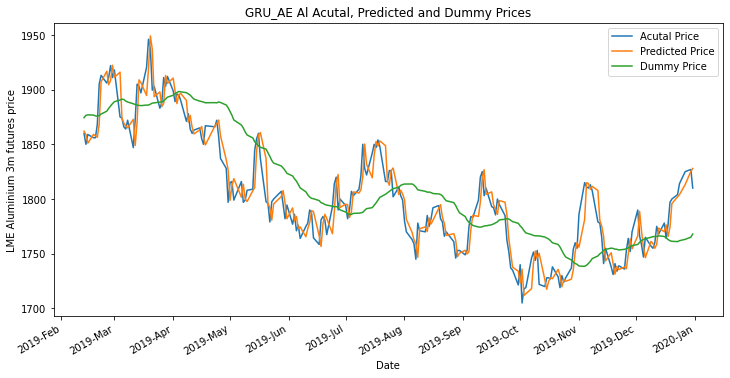

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

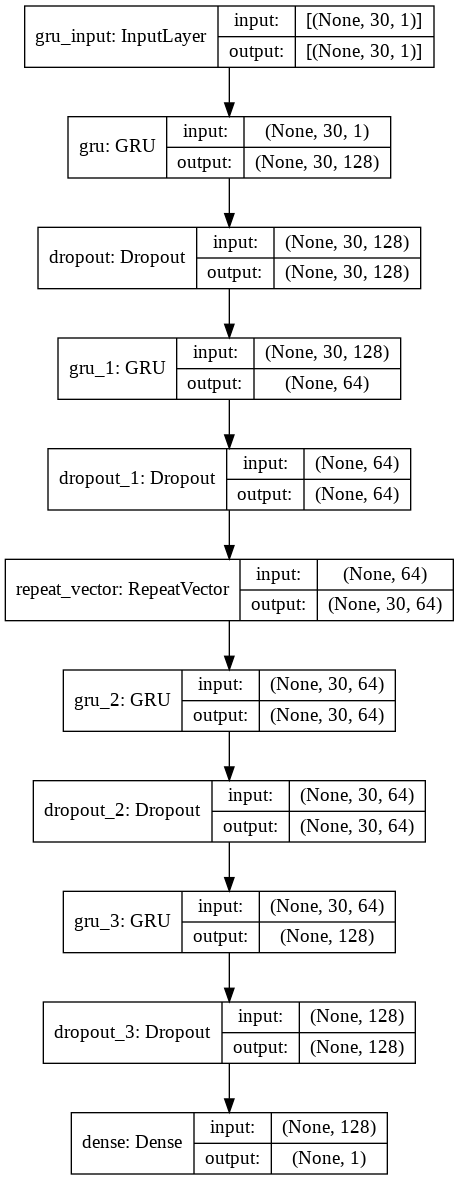

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0037192022312636107
RMSE:  0.060985262410385765
MAE:  0.04841169253596949
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Al/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Al/assets
